# Load Dependencies

In [2]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
import tensorflow
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from scripts import commons
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.activations import relu, tanh, sigmoid
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
warnings.filterwarnings('ignore')

# Pre-processing Data

## Import the dataframes

In [3]:
# Assuming you're in mtg-jamendo-dataset
input_file = "./data/autotagging_moodtheme.tsv"
tracks, tags, extra = commons.read_file(input_file)

tracks

Reading: 18486 tracks, 4506 albums, 1533 artists


{948: {'artist_id': 87,
  'album_id': 149,
  'path': '48/948.mp3',
  'duration': 212.7,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 950: {'artist_id': 87,
  'album_id': 149,
  'path': '50/950.mp3',
  'duration': 248.0,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 951: {'artist_id': 87,
  'album_id': 149,
  'path': '51/951.mp3',
  'duration': 199.7,
  'tags': ['mood/theme---background'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'background'}},
 2165: {'artist_id': 326,
  'album_id': 347,
  'path': '65/2165.mp3',
  'duration': 229.0,
  'tags': ['mood/theme---film'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'film'}},
 2263: {'artist_id': 320,
  'album_id': 366,
  'path': '63/2263.mp3',
  'duration': 494.7,
  'tags': ['mood/theme---melancholic'],
  'genre': set(),
  'instrument': set(),
  'mood/theme': {'melancholic'}},

In [4]:
# # Read the TSV file into a DataFrame
# df = pd.read_csv('./data/autotagging_moodtheme.tsv', sep = '\t', on_bad_lines = 'warn') # This loses about half the dataset which contains multiple tags

# # Filter rows where "PATH" starts with "00/"
# df = df[df['PATH'].str.startswith('00/')]

# # Filter rows where "TAGS" contain only the specified mood/theme tags
# allowed_tags = {'energetic', 'relaxing', 'emotional', 'dark', 'love', 'sad'}  # Use a set for faster membership check
# df['TAGS'] = df['TAGS'].apply(lambda tags: set(tags.split('---')))
# df = df[df['TAGS'].apply(lambda tags: any(tag in allowed_tags for tag in tags))]

# # Display the filtered DataFrame
# print(df)

In [5]:
# # Define the folder containing the audio files
# audio_folder = './audio_data'

# def get_features_and_labels(data):
#     features = []  # List to save features
#     labels = []  # List to save labels
#     for track_id, track_data in data.items():
#         # Check if the path starts with "00/"
#         if track_data['path'].startswith('00/'):
#             # Check if "mood/theme" contains only the specified words
#             if (tag in track_data['mood/theme'] for tag in ['energetic', 'relaxing', 'emotional', 'dark', 'love', 'sad']):
#                 # Load the audio file
#                 filename = track_data['path']
#                 updated_filename = filename.rsplit('.mp3', 1)[0] + '.low.mp3'
#                 filepath = os.path.join(audio_folder, updated_filename)
#                 y, sr = librosa.load(filepath, sr=28000)
#                 # Extract features
#                 # You can modify this part according to your feature extraction needs
#                 # For example, you can extract MFCCs as follows:
#                 mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
#                 # Append features and labels
#                 features.append(mfccs)
#                 labels.append(track_id)  # Use track_id as label
#     # Convert lists to numpy arrays
#     features_array = np.array(features)
#     labels_array = np.array(labels)
#     return features_array, labels_array

# # Get features and labels
# X, y = get_features_and_labels(tracks)

# # Now X contains the features extracted from the audio files
# # and y contains the corresponding track IDs as labels

## Extract features and labels

In [6]:
import os
import librosa
import numpy as np

audio_folder = './audio_data'

def get_mfcc_features_and_labels(data, max_len = None):
    features = []
    labels = []
    max_len = 0
    # audio_files = ['00/', '01/', '02/']

    for track_id, track_data in data.items():
        # if track_data['path'].startswith('00/') or track_data['path'].startswith('01/') or track_data['path'].startswith('02/') or track_data['path'].startswith('03/') \
        #     or track_data['path'].startswith('04/') or track_data['path'].startswith('05/') or track_data['path'].startswith('06/') track_data['path'].startswith('07/') \
        #         or track_data['path'].startswith('08/') or track_data['path'].startswith('09/') or track_data['path'].startswith('10/'):
        if any(track_data['path'].startswith(str(i) + '/') for i in range(30)):
            # if (tag in track_data['mood/theme'] for tag in ['energetic', 'relaxing', 'emotional', 'dark', 'love', 'sad']):
            if all(tag in ['energetic', 'relaxing', 'love', 'sad', 'dark', 'happy'] for tag in track_data['mood/theme']):
                try:
                    # Load the audio file
                    filename = track_data['path']
                    updated_filename = filename.rsplit('.mp3', 1)[0] + '.low.mp3'
                    filepath = os.path.join(audio_folder, updated_filename)
                    y, sr = librosa.load(filepath, sr = 10000)

                    # Trim the beginning and ending silence
                    y_trimmed, index = librosa.effects.trim(y)

                    # Extract MFCCs
                    mfccs = librosa.feature.mfcc(y = y_trimmed, sr = sr, n_mfcc = 10)
                    # print(f"The max length now is {max_len}; the mfccs.shape is {mfccs.shape}")

                    # Update max_len if necessary
                    max_len = max(max_len, mfccs.shape[1])

                    # Append MFCCs and track_id to lists
                    # features.append(mfccs.T)  # Transpose MFCCs array
                    features.append(mfccs)
                    labels.append(track_data['mood/theme'])
                except Exception as e:
                    print(f"Error processing track {track_id}: {e}")

    # Pad or truncate MFCCs arrays to ensure they all have the same length
    padded_features = []
    for mfccs in features:
        padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode = 'constant')
        padded_features.append(padded_mfccs)

    # Convert lists to numpy arrays
    features_array = np.array(padded_features)

    return features_array, labels

# Assuming 'tracks' is the dictionary containing track data
X_mfcc, y = get_mfcc_features_and_labels(tracks)


In [7]:
print("Features shape:", X_mfcc.shape)
# print(X)
# print("Labels:", y)
print("Labels Length:", len(y))

Features shape: (559, 10, 66915)
Labels Length: 559


In [8]:
# print("Features shape:", X[0].shape)
# print(X[0])
# print("Labels:", y[0])

## Represent the labels numerically (encoding)

In [9]:
# # Convert the labels to numerical labels using label encoding
# label_encoder = LabelEncoder()
# encoded_labels = [label_encoder.fit_transform(list(label)) for label in y]
# print(encoded_labels)

# # Pad or truncate the encoded labels to ensure they have the same length
# max_label_length = max(len(label) for label in encoded_labels)
# padded_labels = [np.pad(label, (0, max_label_length - len(label)), mode = 'constant') for label in encoded_labels]
# print(padded_labels)

# # Convert the list of padded labels into a numpy array
# labels_array = np.array(padded_labels)

# print(labels_array)

In [10]:
# Create a MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer and transform labels into binary arrays
y_encoded = mlb.fit_transform(y)



In [11]:
print(y_encoded)
np.sum(y_encoded)

row_sums = np.sum(y_encoded, axis = 1)

mask = row_sums > 1

indices = np.where(mask)[0]

print("Rows with sum greater than 1:", indices)

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ...
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]]
Rows with sum greater than 1: [ 65  68  82 152 202 226 244 320 321 325 338 344 352 382 383 384 385 386
 387 401 415 416 419 435 436 457 464 465 484 495 505 509 516 528 540]


In [12]:
print(y_encoded[65])
print(y_encoded[68])

[0 0 0 0 1 1]
[0 1 1 0 0 0]


## To decode the labels

In [13]:
# Inverse transform binary arrays back into sets of labels
# decoded_labels = mlb.inverse_transform(y_encoded)

# print(decoded_labels)

## Normalise the features

In [14]:
X_normalised = np.array((X_mfcc-np.min(X_mfcc))/(np.max(X_mfcc)-np.min(X_mfcc)))
X_normalised = X_normalised/np.std(X_normalised)

In [15]:
# X_normalised

In [16]:
# type(y)
# y

# Extract training, test and validation datasets

In [17]:
# Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X_normalised, y_encoded, test_size = 0.2, random_state = 88, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 88)

# Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((357, 10, 66915), (112, 10, 66915), (90, 10, 66915), 357, 112, 90)

In [18]:
input_shape = (X_train.shape[1], X_train.shape[2])

# Training Model 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = tensorflow.keras.Sequential()
model.add(LSTM(X_train.shape[1], input_shape = input_shape))
# model.add(Dropout(0.1))
# model.add(Dense(X_train.shape[1], activation ='relu'))
model.add(Dense(6, activation ='softmax'))
model.summary()
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.compile(
    # optimizer = tensorflow.keras.optimizers.legacy.Adam(1e-3),
    optimizer = 'adam', 
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
# history = model.fit(
#     X_train, 
#     y_train, 
#     epochs = 2, 
#     validation_data = (X_val, y_val), 
#     shuffle = False
#     )

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 8, # You can change it
    verbose = 0,
    mode = "auto",
    baseline = None,
    restore_best_weights = False,
    start_from_epoch = 0,
)
]

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = (X_val, y_val),
)

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_values, 'co', label='Training Loss')
ax1.plot(epochs, val_loss_values, 'm', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs, acc_values, 'co', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'm', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# Training Model 2
**Changes**
1. Output Layer Activation Function: Changed the activation function of the output layer from softmax to sigmoid. The sigmoid activation function will allow each output unit to produce a value between 0 and 1, representing the probability of each class being present.

2. Loss Function: Changed the loss function from 'categorical_crossentropy' to 'binary_crossentropy'. Since we're dealing with multi-label classification, binary cross-entropy is more suitable as it's designed for scenarios where each class is considered independently.

In [ ]:
# Modify the output layer activation function and loss function
model2 = tensorflow.keras.Sequential()
model2.add(LSTM(X_train.shape[1], input_shape = input_shape))
model2.add(Dense(6, activation = 'sigmoid'))  # Change softmax to sigmoid
model2.summary()

model2.compile(
    # optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
    optimizer = 'adam',
    loss = 'binary_crossentropy',  # Change loss function
    metrics = ['accuracy']  # Change to accuracy
)

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 8, # You can change it
    verbose = 0,
    mode = "auto",
    baseline = None,
    restore_best_weights = False,
    start_from_epoch = 0,
)
]

# Train the model2
history2 = model2.fit(
    X_train, y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)


In [ ]:
# Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict = history2.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']  # Change to 'accuracy'
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']  # Change to 'val_accuracy'
epochs = range(1, len(loss_values) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_values, 'co', label='Training Loss')
ax1.plot(epochs, val_loss_values, 'm', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs, acc_values, 'co', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'm', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()


# Implementing GridSearch

In [ ]:
# Define a function to create the model
def create_model(optimizer='adam', loss='binary_crossentropy'):
    model = tensorflow.keras.Sequential([
        LSTM(X_train.shape[1], input_shape=input_shape),
        Dense(6, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Define the hyperparameters grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],  # Add other optimizers if desired
    'loss': ['binary_crossentropy', 'categorical_crossentropy']  # Add other loss functions if desired
}

In [ ]:
# Wrap the Keras model as a scikit-learn estimator
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Perform GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, scoring='roc_auc')
grid_result = grid.fit(X_train, y_train, validation_data = (X_val, y_val))

# Print the best parameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Record the hyperparameters and performance metrics
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('grid_search_results.csv', index=False)

In [ ]:
# Load the results from the grid search
results = pd.read_csv('grid_search_results.csv')

# Extract the relevant columns
params = results[['param_optimizer', 'param_loss']]
val_acc = results['mean_test_score']

# Plot the validation accuracy for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.bar(range(len(val_acc)), val_acc, color='skyblue')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Validation Accuracy')
plt.title('GridSearchCV Results')
plt.xticks(range(len(val_acc)), [f"{optimizer}, {loss}" for optimizer, loss in zip(params['param_optimizer'], params['param_loss'])], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Expanding the GridSearch

In [ ]:
# Define a function to create the model
def create_model(units=30, dropout_rate=0, recurrent_layer=LSTM, num_layers=1,
                 optimizer='adam', loss='binary_crossentropy', activation='sigmoid'):
    model = tensorflow.keras.Sequential()
    
    # Add the first recurrent layer
    model.add(recurrent_layer(units, input_shape=input_shape, return_sequences=(num_layers > 1)))
    model.add(Dropout(dropout_rate))
    
    # Add additional recurrent layers if specified
    for _ in range(num_layers - 1):
        model.add(recurrent_layer(units, return_sequences=(num_layers > 1)))
        model.add(Dropout(dropout_rate))
    
    # Add the final output layer
    model.add(Dense(6, activation=activation))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

# Define the hyperparameters grid
param_grid = {
    'units': [10, 20, 30],  # Experiment with different numbers of units in the LSTM layer
    # 'dropout_rate': [0.1, 0.2, 0.3],  # Experiment with different dropout rates
    # 'recurrent_layer': [LSTM, GRU],  # Experiment with different types of recurrent layers
    'recurrent_layer': [LSTM],
    'num_layers': [1, 2],  # Experiment with adding additional recurrent layers
    # 'optimizer': ['adam', 'rmsprop'],  # Experiment with different optimizers
    'optimizer': ['adam'],  # Experiment with different optimizers
    # 'loss': ['binary_crossentropy', 'categorical_crossentropy'],  # Experiment with different loss functions
    'loss': ['binary_crossentropy'],  # Experiment with different loss functions
    'activation': ['sigmoid', 'relu', 'tanh']  # Experiment with different activation functions
}

In [ ]:
# Wrap the Keras model as a scikit-learn estimator
model = KerasClassifier(
    build_fn=create_model, 
    epochs=10, 
    batch_size=32, 
    verbose=0, 
    activation="sigmoid", 
    dropout_rate=0.1, 
    num_layers=1,
    recurrent_layer='keras.src.layers.rnn.lstm.LSTM',
    units = 20
    )

# Perform GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy')
grid_result = grid.fit(X_train, y_train, validation_data = (X_val, y_val))

# Print the best parameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Record the hyperparameters and performance metrics
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('grid_search_results2.csv', index=False)

In [ ]:
# Load the results from the grid search
results = pd.read_csv('grid_search_results2.csv')

# Extract the relevant columns
params = results[['param_optimizer', 'param_loss']]
val_acc = results['mean_test_score']

# Plot the validation accuracy for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.bar(range(len(val_acc)), val_acc, color='skyblue')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Validation Accuracy')
plt.title('GridSearchCV Results')
plt.xticks(range(len(val_acc)), [f"{optimizer}, {loss}" for optimizer, loss in zip(params['param_optimizer'], params['param_loss'])], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Creating Checkpoints

In [19]:
def create_checkpoint():
    checkpoint = ModelCheckpoint('best_model.h9',  # Path to save the model weights
                                 monitor='val_accuracy',  # Metric to monitor
                                 verbose=1,  # Output progress information
                                 save_best_only=True,  # Save only the best model
                                 mode='max',  # Save the model with the highest monitored metric
                                 save_weights_only=True)  # Save only the model weights
    return checkpoint

In [20]:
# Define the hyperparameters grid
param_grid = {
    'units': [5, 10],  # Experiment with different numbers of units in the LSTM layer
    'dropout_rate': [0.1, 0.15, 0.2, 0.25],  # Experiment with different dropout rates
    # 'recurrent_layer': [LSTM, GRU],  # Experiment with different types of recurrent layers
    'recurrent_layer': [LSTM],
    'num_layers': [1],  # Experiment with adding additional recurrent layers
    # 'optimizer': ['adam', 'rmsprop'],  # Experiment with different optimizers
    'optimizer': ['adam'],  # Experiment with different optimizers
    # 'loss': ['binary_crossentropy', 'categorical_crossentropy'],  # Experiment with different loss functions
    'loss': ['binary_crossentropy'],  # Experiment with different loss functions
    'activation': ['tanh', 'elu']  # Experiment with different activation functions
}

In [21]:
# Define a function to create the model
def create_model(units=30, dropout_rate=0, recurrent_layer=LSTM, num_layers=1,
                 optimizer='adam', loss='binary_crossentropy', activation='sigmoid'):
    model = Sequential()
    
    # Add the first recurrent layer
    model.add(recurrent_layer(units, input_shape=input_shape, return_sequences=(num_layers > 1)))
    model.add(Dropout(dropout_rate))
    
    # Add additional recurrent layers if specified
    for _ in range(num_layers - 1):
        model.add(recurrent_layer(units, return_sequences=(num_layers > 1)))
        model.add(Dropout(dropout_rate))
    
    # Add the final output layer with appropriate activation function
    if activation == 'sigmoid':
        model.add(Dense(6, activation='sigmoid'))  # Change 6 to the number of classes
    else:
        model.add(Dense(6, activation=activation))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [22]:
# Wrap the Keras model as a scikit-learn estimator
model = KerasClassifier(
    build_fn=create_model, 
    epochs=10, 
    batch_size=32, 
    verbose=0, 
    activation="sigmoid", 
    dropout_rate=0, 
    num_layers=1,
    recurrent_layer='keras.src.layers.rnn.lstm.LSTM',
    units=20
)

# Create the ModelCheckpoint callback
checkpoint_callback = create_checkpoint()

# Perform GridSearch with the callback
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=2, scoring='accuracy')
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

# Print the best parameters and the corresponding accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Record the hyperparameters and performance metrics
results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('grid_search_results5_accuracy_scoring_with_sd_normalisation.csv', index=False)


Fitting 2 folds for each of 16 candidates, totalling 32 fits


2024-03-17 12:10:52.293789: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-17 12:10:52.293809: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-17 12:10:52.293817: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-17 12:10:52.293867: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-17 12:10:52.293895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-17 12:10:53.344875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:10:53.554746: I t

[CV] END activation=tanh, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   5.9s


2024-03-17 12:10:58.849452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:10:59.006878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:10:59.151733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:10:59.735951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:10:59.803129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:03.029502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:03.090766: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   5.3s


2024-03-17 12:11:04.160366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:04.317340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:04.473392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:05.111523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:05.175314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:08.599968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:08.663288: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   5.6s


2024-03-17 12:11:09.711017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:09.887687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:10.042285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:10.755446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:10.835077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:14.414584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:14.485082: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   5.8s


2024-03-17 12:11:16.077698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:16.244152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:16.427438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:16.985689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:17.059050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:20.258104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:20.322059: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   5.8s


2024-03-17 12:11:21.366617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:21.534164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:21.689548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:22.298580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:22.368932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:25.686113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:25.754649: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   5.4s


2024-03-17 12:11:26.992455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:27.199361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:27.402264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:28.273760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:28.369304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:32.323959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:32.395432: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.7s


2024-03-17 12:11:33.709251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:33.895135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:34.080845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:34.727554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:34.799095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:38.335575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:38.408759: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.0s


2024-03-17 12:11:39.591065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:39.762402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:39.981582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:41.285034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:41.367371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:44.758149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:44.833175: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.4s


2024-03-17 12:11:45.999317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:46.185156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:46.433875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:47.217903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:47.296678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:50.736531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:50.815030: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.0s


2024-03-17 12:11:52.160673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:52.360233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:52.587648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:53.380037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:53.458544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:57.262634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:57.345460: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.5s


2024-03-17 12:11:58.655455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:58.857710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:59.070725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:59.775077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:11:59.843709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:03.313540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:03.395130: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.0s


2024-03-17 12:12:04.484299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:04.648470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:04.902974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:05.674097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:05.754853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:10.156505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:10.287637: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   7.0s


2024-03-17 12:12:13.492240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:13.777477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:14.098784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:14.797410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:14.873865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:18.201624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:18.264407: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   7.8s


2024-03-17 12:12:19.350781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:19.511062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:19.714405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:20.417770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:20.486592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:24.039512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:24.125565: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   5.9s


2024-03-17 12:12:25.502770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:25.725493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:26.002984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:26.847702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:26.931092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:30.597320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:30.674987: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=tanh, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.5s


2024-03-17 12:12:31.955581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:32.155945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:32.454921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:33.334017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:33.409660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:36.988391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:37.068765: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.4s


2024-03-17 12:12:39.093289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:39.295690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:39.589727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:40.301074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:40.379215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:44.951526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:45.052103: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   8.0s


2024-03-17 12:12:46.334648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:46.524416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:46.827767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:47.613791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:47.686096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:51.451873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:51.524847: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.5s


2024-03-17 12:12:52.949820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:53.215458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:53.543729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:54.549354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:54.640177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:58.454266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:12:58.537132: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.1, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   7.0s


2024-03-17 12:12:59.974601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:00.200697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:00.543421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:01.453009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:01.531594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:05.267306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:05.359080: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.8s


2024-03-17 12:13:06.850252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:07.083162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:07.383324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:09.057382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:09.176959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:13.601733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:13.744509: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   8.5s


2024-03-17 12:13:16.074744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:16.354032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:16.757184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:17.834442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:17.934861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:21.845356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:21.926357: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   8.0s


2024-03-17 12:13:23.320424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:23.521930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:23.889236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:24.895131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:24.986359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:29.001299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:29.082810: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.15, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   7.2s


2024-03-17 12:13:30.588827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:30.829073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:31.254361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:32.188847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:32.312058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:36.084124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:36.169297: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   7.1s


2024-03-17 12:13:37.563209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:37.779233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:38.143078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:39.025858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:39.109764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:43.590957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:43.674867: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   7.5s


2024-03-17 12:13:45.875013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:46.086379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:46.486539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:47.309829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:47.382821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:51.077041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:51.154658: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   7.4s


2024-03-17 12:13:52.387660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:52.586664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:52.965886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:53.906033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:53.986954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:58.037763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:58.117568: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.2, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   7.0s


2024-03-17 12:13:59.487310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:13:59.684945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:00.077819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:01.099719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:01.181665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:04.842070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:04.917218: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.8s


2024-03-17 12:14:06.320554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:06.515209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:06.891038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:07.752864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:07.831895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:11.458931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:11.535756: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=5; total time=   6.6s


2024-03-17 12:14:12.691176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:12.869700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:13.223085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:14.131612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:14.200078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:18.107312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:18.187084: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   6.7s


2024-03-17 12:14:20.194863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:20.368252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:20.741593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:21.551473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:21.621118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:25.396642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:25.478081: I tensorflow/core/grappler/optimizers/cust

[CV] END activation=elu, dropout_rate=0.25, loss=binary_crossentropy, num_layers=1, optimizer=adam, recurrent_layer=<class 'keras.src.layers.rnn.lstm.LSTM'>, units=10; total time=   7.3s


2024-03-17 12:14:26.800042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:26.962482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:27.258830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:28.383733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-17 12:14:28.446260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Best: 0.176605 using {'activation': 'elu', 'dropout_rate': 0.15, 'loss': 'binary_crossentropy', 'num_layers': 1, 'optimizer': 'adam', 'recurrent_layer': <class 'keras.src.layers.rnn.lstm.LSTM'>, 'units': 10}


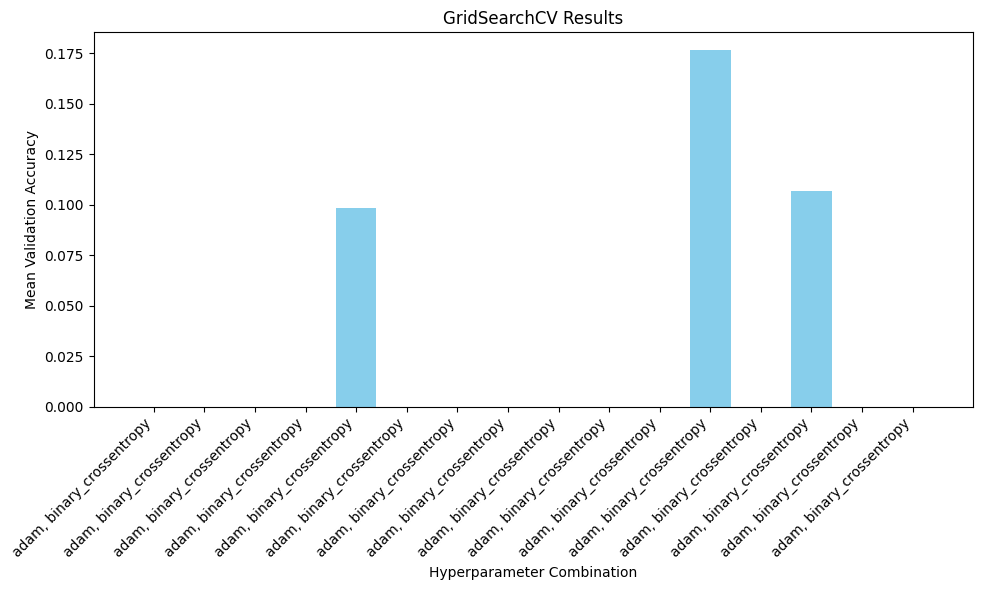

AttributeError: module 'matplotlib' has no attribute 'pyplot'

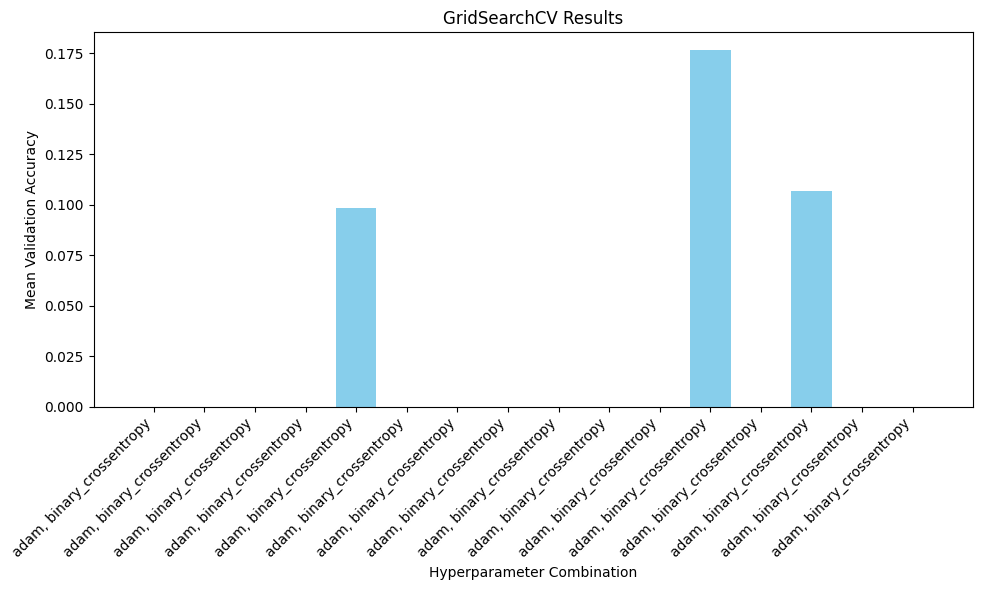

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [23]:
# Load the results from the grid search
results = pd.read_csv('grid_search_results5_accuracy_scoring_with_sd_normalisation.csv')

# Extract the relevant columns
params = results[['param_optimizer', 'param_loss']]
val_acc = results['mean_test_score']

# Plot the validation accuracy for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.bar(range(len(val_acc)), val_acc, color='skyblue')
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Validation Accuracy')
plt.title('GridSearchCV Results')
plt.xticks(range(len(val_acc)), [f"{optimizer}, {loss}" for optimizer, loss in zip(params['param_optimizer'], params['param_loss'])], rotation=45, ha='right')
plt.tight_layout()
plt.show()